<a href="https://colab.research.google.com/github/chavezgranados/Machine-Learning/blob/main/s4/sesion4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font face="gotham" color="purple"> **MACHINE LEARNING IN ECONOMICS 2025: SESIÓN 4**</font>


`Luis Chávez`

![texto del vínculo](https://dais.chbe.ubc.ca/assets/thumbnails/neural.png)

# <font face="gotham" color="purple"> **1. Análisis Cluster**</font>


In [39]:
# Paquetería
# =============================================================================
import matplotlib.pyplot as plt
import pandas as pd
import missingno as msno
import seaborn as sns
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

## <font face="gotham" color="purple"> **1.1 Conceptos básicos**</font>

Forma parte de las técnicas de agrupación el lenguaje no supervisado. Cuyo rol es max-min:
- max distancia intercluster (separación).
- min distancia intracluster (cohesión) $→$ *distancia*

## <font face="gotham" color="purple"> **1.2 Clasificación**</font>

![texto del vínculo](https://www.researchgate.net/publication/362507241/figure/fig3/AS:11431281120889314@1676689305509/Types-of-clustering-algorithms.jpg)

**Fuente**: Nashuha et. al (2022).

## <font face="gotham" color="purple"> **1.3 Aplicaciones en economía**</font>

- Segmentación de mercados.
- Posicionamiento de marcas.
- Nuevos productos.
- Selección de medios publicitarios.
- Segmetación de clientes según nivel de riesgo
- ...

# <font face="gotham" color="purple"> **2. Cluster jerárquico (aglomerativo)**</font>

Pasos:

a) Determinar si es necesario la estandarización de datos.

b) Calcular la matriz de distancias

c) Elegir un método de enlace (agrupamiento)

d) Obtener el dendograma.

e) Elegir el número de clusters.

f) Verificación y validación

## <font face="gotham" color="purple"> **2.1 Medidas de distancia**</font>

1️⃣ Distancia Euclidiana (d)
$$ d(A, B) = \sqrt{\sum_{i=1}^{n} (A_i - B_i)^2} $$

2️⃣ Distancia de Manhattan
$$d(A, B) = \sum_{i=1}^{n} |A_i - B_i|$$

3️⃣ Distancia de Minkowski (generalización)

$$d(A, B) = \left(\sum_{i=1}^{n} |A_i - B_i|^p \right)^{\frac{1}{p}}$$

4️⃣ Distancia de Mahalanobis
$$d(A, B) = \sqrt{(A - B)^T S^{-1} (A - B)}$$

## <font face="gotham" color="purple"> **2.2 Cálculo de distancia**</font>

**Manualmente:**

|   | $x_1$ | $x_2$ |
|---|---|----|
| A | 2 | 4  |
| B | 4 | 7  |
| C | 9 | 10 |

In [40]:
dAB=math.sqrt((2-4)^2 + (4-7)^2)
dAC=math.sqrt((2-9)^2 + (4-10)^2)
dBC=math.sqrt((4-9)^2 + (7-10)^2)
dAB, dAC, dBC

(1.7320508075688772, 2.6457513110645907, 2.449489742783178)

**Usando códigos:**

In [41]:
datos = {'x1': [2, 4, 9], 'x2': [4, 7, 10]}
df = pd.DataFrame(datos, index=['A', 'B', 'C'])
df

,x1,x2
A,2,4
B,4,7
C,9,10


In [42]:
# Distance matrix
def distance_matrix(df):
    n = len(df)
    matrix = pd.DataFrame(index=df.index, columns=df.index)

    for i in range(n):
        for j in range(i,n):
            point1 = df.iloc[i]
            point2 = df.iloc[j]
            distance = math.sqrt(sum([(a - b) ** 2 for a, b in zip(point1, point2)]))
            matrix.iloc[i,j] = distance
            matrix.iloc[j,i] = distance
    return matrix

distance_matrix = distance_matrix(df)
distance_matrix

,A,B,C
A,0.0,3.605551,9.219544
B,3.605551,0.0,5.830952
C,9.219544,5.830952,0.0


> **⚠ Nota:**  
> 🔴 <font face="gotham" color="green"> Los datos deben ser estandarizados si el dataset presentar heterogeneidad.


## <font face="gotham" color="purple"> **2.3 Aplicación**</font>

In [43]:
# Carga de datos
# =============================================================================
data1=pd.read_excel("financi.xlsx")
data1.head(3)

,NumeroOperacion_Ori,estado,riesgo,agencia,plazo_dias,tasa_int,saldoprom_per,saldo_corte,ing_finan,transf,provision_peq_Ori,provision_PEN,gastos_inver,gastos_ind,trans_tot
0,2,Vigentes,BAJO,AG. ICA,2214,10.9,104636.35,104331.39,935.94,-866.44,-13.51,1043.31,0.420345,5.531587,-857.80089
1,3,Vencidos,MEDIO,AG. CARSA HUANUCO,2241,11.5,2.97,0.00,0.00,-0.02,0.00,0.00,0.000000,0.000000,-0.02000
2,3,Vigentes,MEDIO,AG. CARSA HUANUCO,2241,11.5,43728.89,43535.45,406.18,-356.92,-27.69,2176.77,0.420345,198.299100,-339.15306


In [44]:
len(data1)

1455

In [45]:
data1 = data1.drop_duplicates(subset=['NumeroOperacion_Ori'], keep='first')

In [46]:
# Filtro
# =============================================================================
data2 = data1[['plazo_dias', 'tasa_int', 'saldo_corte', 'provision_peq_Ori', 'provision_PEN']].copy()
data2.head()

,plazo_dias,tasa_int,saldo_corte,provision_peq_Ori,provision_PEN
0,2214,10.90,104331.39,-13.51,1043.31
1,2241,11.50,0.00,0.00,0.00
3,2234,10.30,72606.85,-10.20,726.07
4,2223,12.65,41200.54,-5.46,412.01
5,2217,10.80,90436.85,-12.56,904.37


In [47]:
len(data2)

1274

In [48]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1274 entries, 0 to 1454
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   plazo_dias         1274 non-null   int64  
 1   tasa_int           1274 non-null   float64
 2   saldo_corte        1274 non-null   float64
 3   provision_peq_Ori  1274 non-null   float64
 4   provision_PEN      1274 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 59.7 KB


<Figure size 1000x500 with 0 Axes>

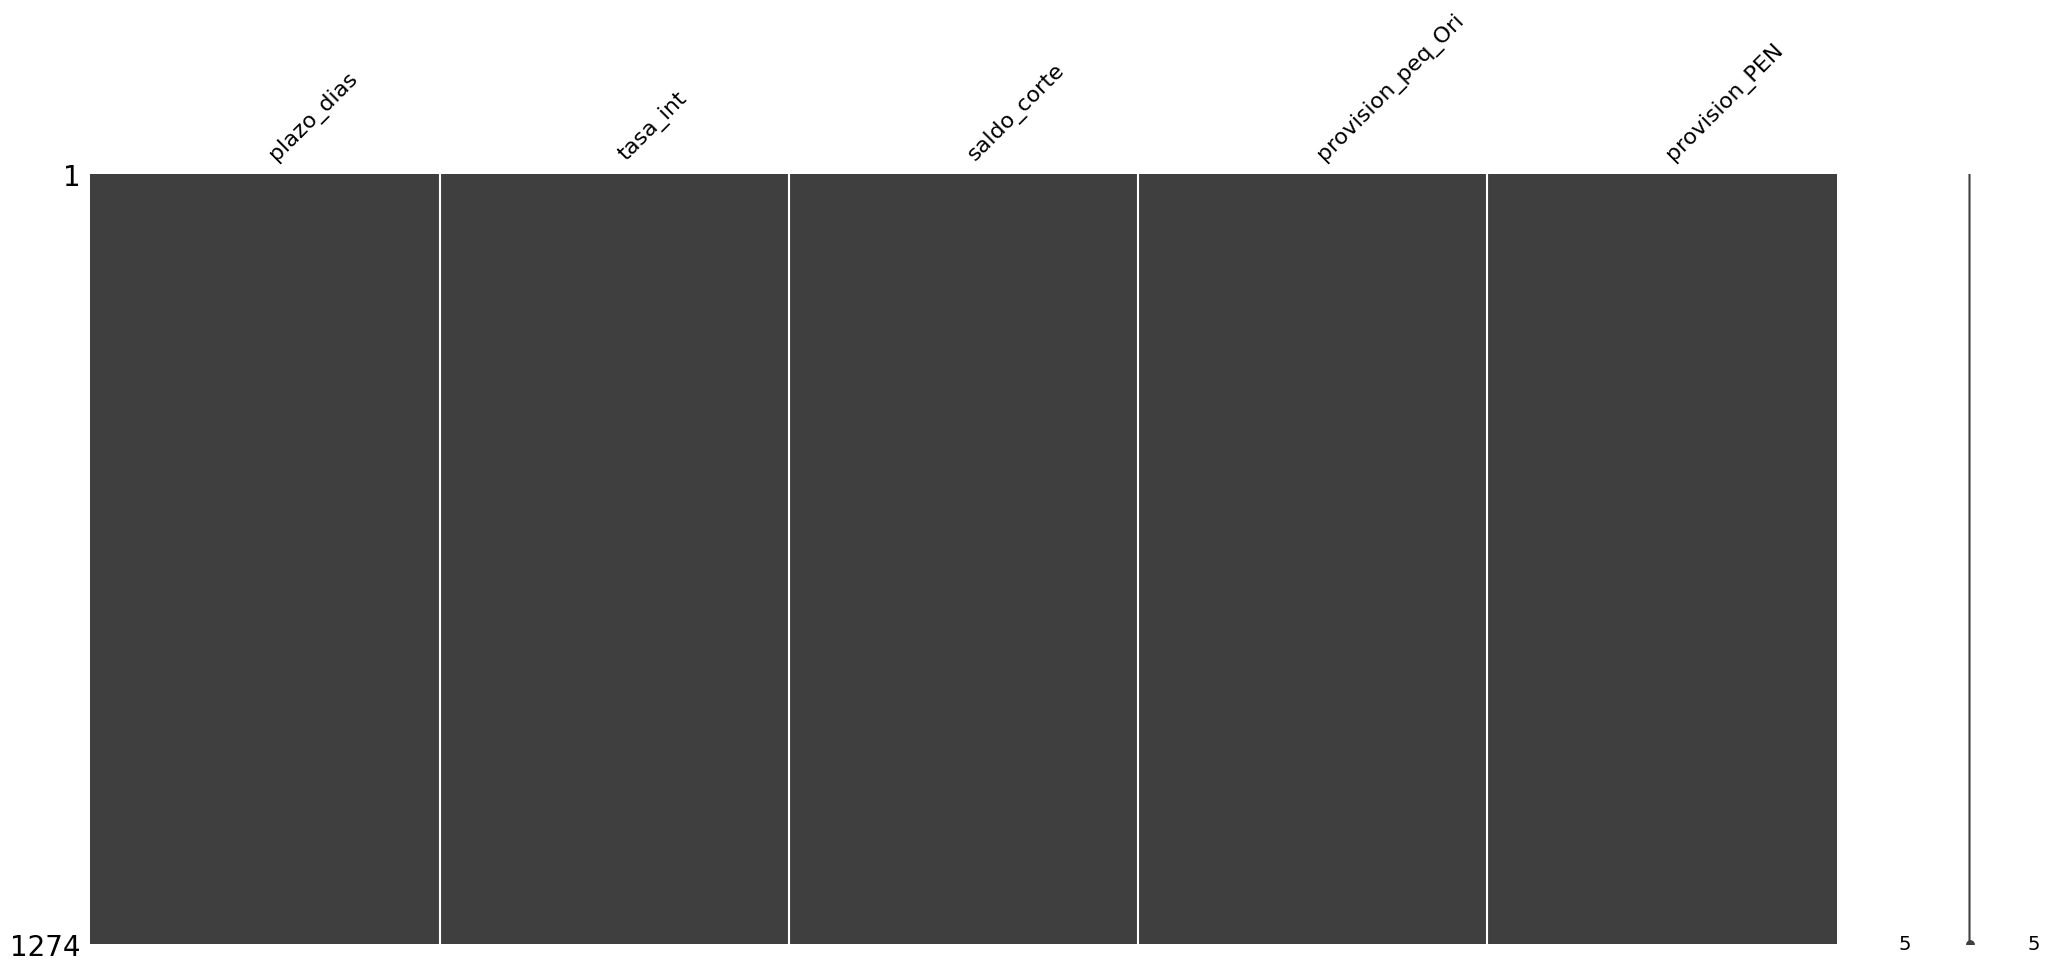

In [49]:
# Detección de missings
# =============================================================================
plt.figure(figsize=(10, 5))
msno.matrix(data2)
plt.show()

In [50]:
# Entandarización de datos
# =============================================================================
scaler = StandardScaler()
datos_e = pd.DataFrame(scaler.fit_transform(data2), columns=data2.columns)
datos_e.head()

,plazo_dias,tasa_int,saldo_corte,provision_peq_Ori,provision_PEN
0,0.227174,-0.608508,1.655139,-0.071132,-0.109508
1,0.267288,-0.434844,-1.650070,-0.064879,-0.238441
2,0.256888,-0.782171,0.650108,-0.069600,-0.148713
3,0.240545,-0.101990,-0.344841,-0.067406,-0.187525
4,0.231631,-0.637452,1.214961,-0.070692,-0.126678


In [51]:
# Matriz de distacias euclidiana
# =============================================================================
dist_eucl = pdist(datos_e, metric="euclidean")
dist_matrix = squareform(dist_eucl)
print(np.round(dist_matrix[:6, :6], 1))

[[0.  3.3 1.  2.1 0.4 0.5]
 [3.3 0.  2.3 1.3 2.9 3.3]
 [1.  2.3 0.  1.2 0.6 1.1]
 [2.1 1.3 1.2 0.  1.7 2.1]
 [0.4 2.9 0.6 1.7 0.  0.7]
 [0.5 3.3 1.1 2.1 0.7 0. ]]


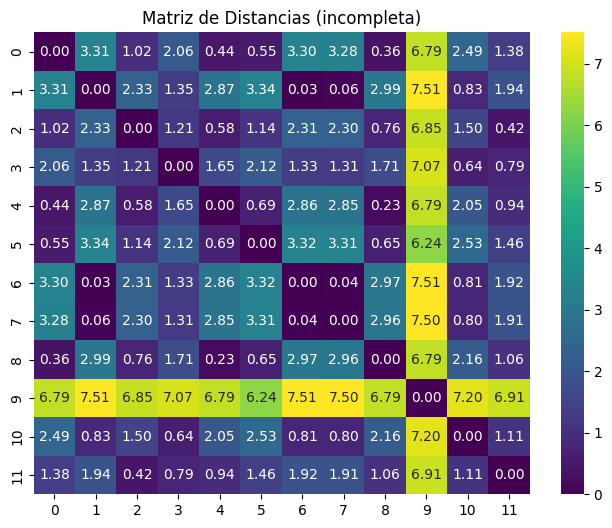

In [52]:
sub_matrix = dist_matrix[:12, :12] # para heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(sub_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Matriz de Distancias (incompleta)')
plt.show()

In [53]:
# Enlaces usando Ward
# =============================================================================
linkage_matrix = sch.linkage(dist_matrix, method="ward")

<ipython-input-53-70b55d3819db>:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(dist_matrix, method="ward")


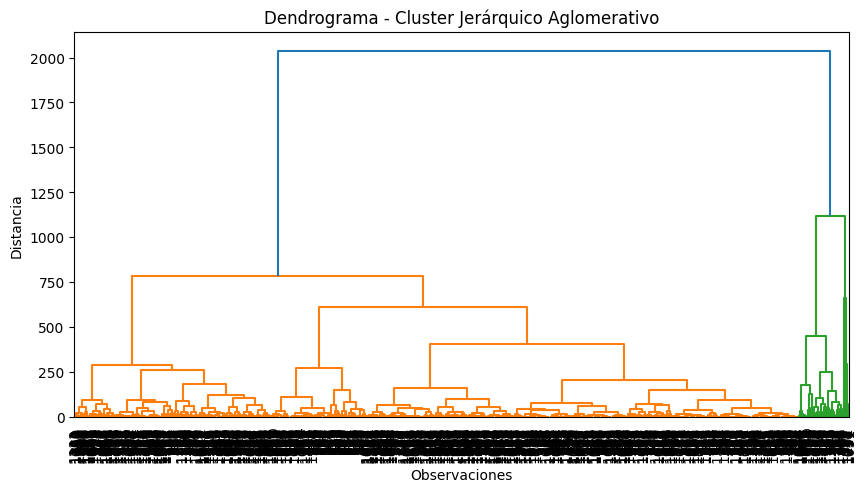

In [54]:
# Dendograma
# =============================================================================
plt.figure(figsize=(10, 5))
sch.dendrogram(linkage_matrix, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrograma - Cluster Jerárquico Aglomerativo")
plt.xlabel("Observaciones")
plt.ylabel("Distancia")
plt.show()

In [55]:
 # Añadimos la variable cluster al DF
clusters = fcluster(linkage_matrix, 3, criterion='maxclust')
datos_e['Cluster'] = clusters
datos_e.head()

,plazo_dias,tasa_int,saldo_corte,provision_peq_Ori,provision_PEN,Cluster
0,0.227174,-0.608508,1.655139,-0.071132,-0.109508,1
1,0.267288,-0.434844,-1.650070,-0.064879,-0.238441,1
2,0.256888,-0.782171,0.650108,-0.069600,-0.148713,1
3,0.240545,-0.101990,-0.344841,-0.067406,-0.187525,1
4,0.231631,-0.637452,1.214961,-0.070692,-0.126678,1


In [56]:
cluster_counts = datos_e['Cluster'].value_counts()
print(cluster_counts)

Cluster
1    1190
2      74
3      10
Name: count, dtype: int64


In [57]:
# Número óptimo de clusters - silueta
# =============================================================================
# Probar diferentes números de clusters
for k in range(2, 10):
    clusters = fcluster(linkage_matrix, k, criterion='maxclust')
    sil_score = silhouette_score(datos_e, clusters)
    print(f"Número de clusters: {k}, Silhouette Score: {sil_score:.4f}")

Número de clusters: 2, Silhouette Score: 0.6822
Número de clusters: 3, Silhouette Score: 0.6525
Número de clusters: 4, Silhouette Score: 0.3492
Número de clusters: 5, Silhouette Score: 0.3493
Número de clusters: 6, Silhouette Score: 0.2970
Número de clusters: 7, Silhouette Score: 0.2969
Número de clusters: 8, Silhouette Score: 0.2427
Número de clusters: 9, Silhouette Score: 0.2418


> **Cuanto mayor sea el índice de silueta, mejor es la grupación.**



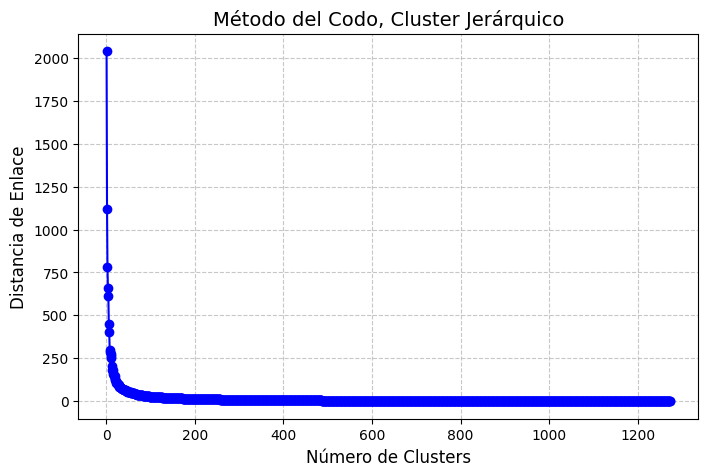

In [58]:
# Número óptimo de clusters - elbow (codo)
# =============================================================================
distances = linkage_matrix[:, 2]

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(distances) + 1), distances[::-1], marker='o', linestyle='-', color='b')
plt.xlabel('Número de Clusters', fontsize=12)
plt.ylabel('Distancia de Enlace', fontsize=12)
plt.title('Método del Codo, Cluster Jerárquico', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## <font face="gotham" color="purple"> **2.4 Casito**</font>

In [59]:
# Datos
# =============================================================================
datos3 = datos_e.sample(frac=0.1, random_state=1234)
del datos3['Cluster'] #viene de la clusterización de la otra base
print(datos3.head())

      plazo_dias  tasa_int  saldo_corte  provision_peq_Ori  provision_PEN
1000   -0.257163 -0.290125     0.832771          -0.071387      -0.141587
1060    0.236088 -0.261181     1.807885          -0.069906      -0.103549
1045   -2.496110 -0.579564    -1.279452          -0.069119      -0.223984
817    -1.411551  0.691073    -1.633968          -0.064879      -0.238441
290     0.262831 -0.290125     0.275228          -0.068540      -0.163337


<ipython-input-60-517c53a402ca>:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link_matrix1 = sch.linkage(matrix1, method="ward")


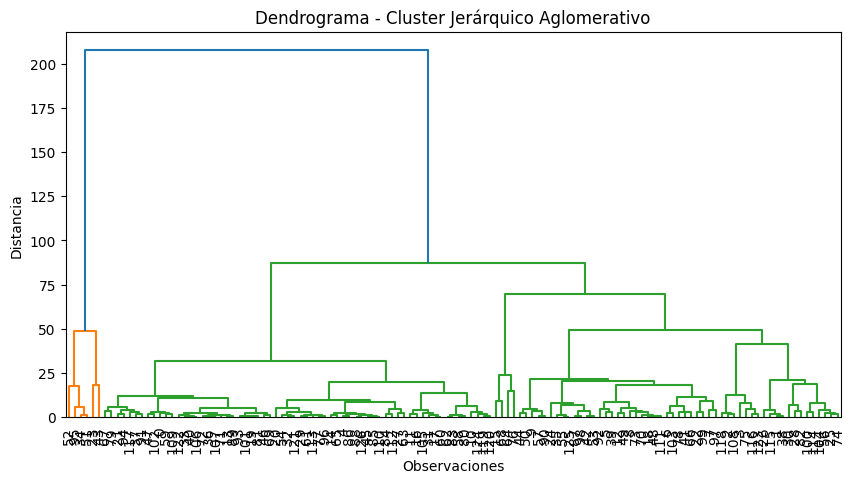

In [60]:
d1 = pdist(datos3, metric="euclidean")
matrix1= squareform(d1)
link_matrix1 = sch.linkage(matrix1, method="ward")

plt.figure(figsize=(10, 5))
sch.dendrogram(link_matrix1, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrograma - Cluster Jerárquico Aglomerativo")
plt.xlabel("Observaciones")
plt.ylabel("Distancia")
plt.show()

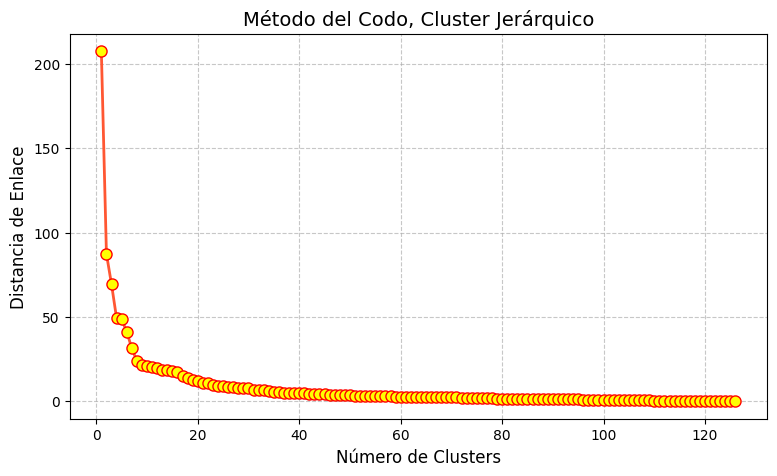

In [61]:
# Elbow
# =============================================================================
distances = link_matrix1[:, 2]

plt.figure(figsize=(9, 5))
plt.plot(range(1, len(distances) + 1), distances[::-1], marker='o', linestyle='-',
         color='#ff5733', markersize=8, markerfacecolor='yellow', markeredgecolor='red', linewidth=2)
plt.xlabel('Número de Clusters', fontsize=12)
plt.ylabel('Distancia de Enlace', fontsize=12)
plt.title('Método del Codo, Cluster Jerárquico', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [62]:
# Identificación de clusters
# =============================================================================
clus = fcluster(link_matrix1, 4, criterion='maxclust') # 4 clusters
datos3['Cluster'] = clus
datos3.head()

,plazo_dias,tasa_int,saldo_corte,provision_peq_Ori,provision_PEN,Cluster
1000,-0.257163,-0.290125,0.832771,-0.071387,-0.141587,2
1060,0.236088,-0.261181,1.807885,-0.069906,-0.103549,4
1045,-2.496110,-0.579564,-1.279452,-0.069119,-0.223984,4
817,-1.411551,0.691073,-1.633968,-0.064879,-0.238441,4
290,0.262831,-0.290125,0.275228,-0.068540,-0.163337,2


In [63]:
cluster_c = datos3['Cluster'].value_counts()
print(cluster_c)

Cluster
2    64
4    53
1     6
3     4
Name: count, dtype: int64


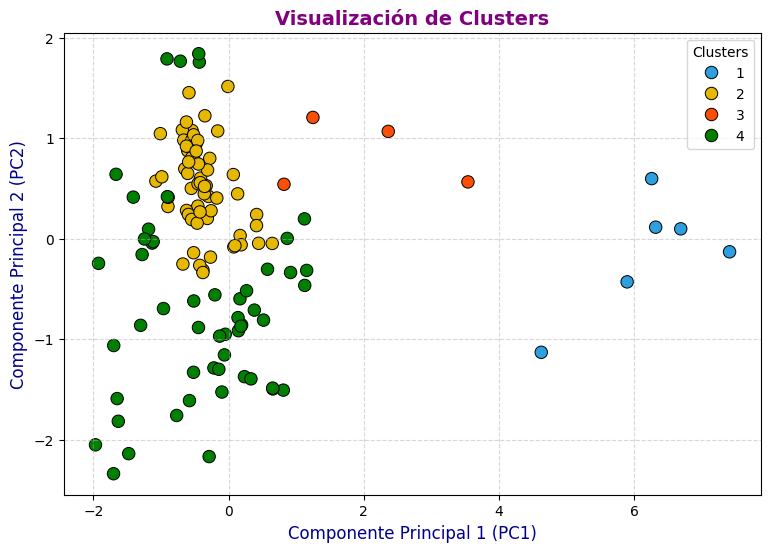

In [64]:
# Gráficos de clusters
# =============================================================================
pca = PCA(n_components=2)
datos3[['PC1', 'PC2']] = pca.fit_transform(datos3.drop(columns=["Cluster"]))  # Omitimos la columna de cluster

# Crear el gráfico
plt.figure(figsize=(9, 6))
sns.scatterplot(data=datos3, x="PC1", y="PC2", hue="Cluster",
                palette=["#2E9FDF", "#E7B800", "#FC4E07", "green"], s=80, edgecolor='black')

# Estilo del gráfico
plt.title("Visualización de Clusters", fontsize=14, fontweight="bold", color="purple")
plt.xlabel("Componente Principal 1 (PC1)", fontsize=12, color="darkblue")
plt.ylabel("Componente Principal 2 (PC2)", fontsize=12, color="darkblue")
plt.legend(title="Clusters")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

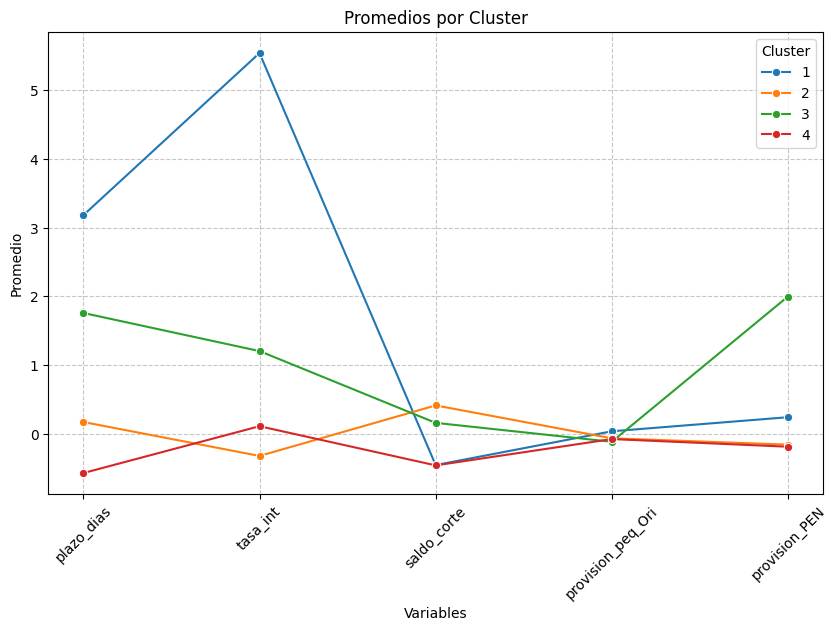

In [65]:
# Caracterización de clusters
# =============================================================================
del datos3['PC1']
del datos3['PC2']
cluster_means = datos3.groupby("Cluster").mean()
plt.figure(figsize=(10, 6))
sns.lineplot(data=cluster_means.T, marker="o", dashes=False, palette="tab10")
plt.xlabel("Variables")
plt.ylabel("Promedio")
plt.title("Promedios por Cluster")
plt.legend(title="Cluster")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.show()

# <font face="gotham" color="purple"> **3. Cluster de partición (K-MEANS)**</font>

In [66]:
# Paquetes
# =============================================================================
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [67]:
# Datos
datosK = datos_e.drop('Cluster', axis=1)
datosK.head()

,plazo_dias,tasa_int,saldo_corte,provision_peq_Ori,provision_PEN
0,0.227174,-0.608508,1.655139,-0.071132,-0.109508
1,0.267288,-0.434844,-1.650070,-0.064879,-0.238441
2,0.256888,-0.782171,0.650108,-0.069600,-0.148713
3,0.240545,-0.101990,-0.344841,-0.067406,-0.187525
4,0.231631,-0.637452,1.214961,-0.070692,-0.126678


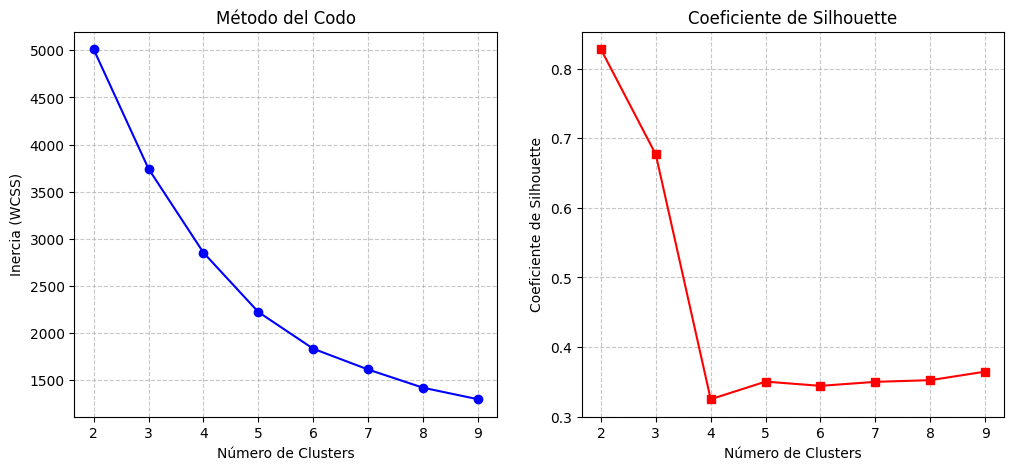

In [69]:
# Identificación de k
# =============================================================================
wcss = []  # Inercia (Elbow)
silhouette_scores = []  # Silhouette

# Probar diferentes números k
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(datosK)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(datosK, kmeans.labels_))

# Codo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 10), wcss, marker="o", linestyle="-", color="b")
plt.xlabel("Número de Clusters")
plt.ylabel("Inercia (WCSS)")
plt.title("Método del Codo")
plt.grid(True, linestyle="--", alpha=0.7)

# Gráfico del coeficiente de silhouette
plt.subplot(1, 2, 2)
plt.plot(range(2, 10), silhouette_scores, marker="s", linestyle="-", color="r")
plt.xlabel("Número de Clusters")
plt.ylabel("Coeficiente de Silhouette")
plt.title("Coeficiente de Silhouette")
plt.grid(True, linestyle="--", alpha=0.7)

plt.show()

In [85]:
# k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters0 = kmeans.fit_predict(datosK)  # Asigna cada fila a un cluster

# Agregar los clusters al dataset original
datosK["Cluster"] = clusters0
cluster_c2 = datosK['Cluster'].value_counts()
print(cluster_c2)

Cluster
0    674
2    548
3     43
1      9
Name: count, dtype: int64


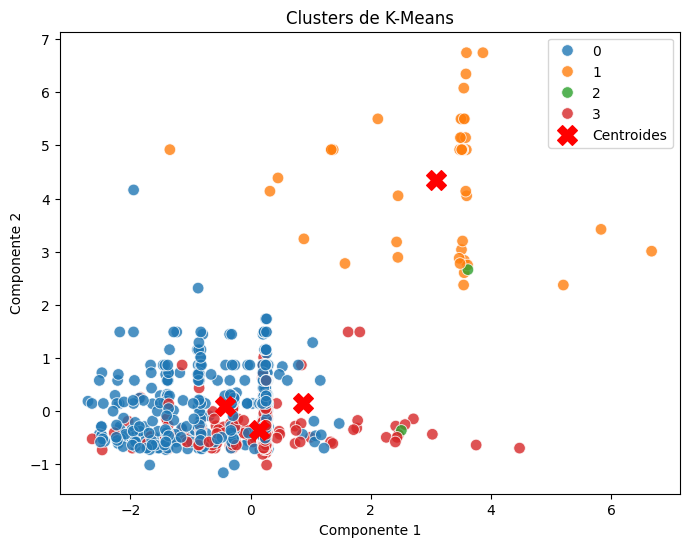

In [81]:
# Gráfico
# =============================================================================
plt.figure(figsize=(8, 6))
sns.scatterplot(x=datosK.iloc[:, 0], y=datosK.iloc[:, 1], hue=clusters0, palette="tab10", s=70, alpha=0.8)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c="red", marker="X", s=200, label="Centroides")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.title("Clusters de K-Means")
plt.legend()
plt.show()


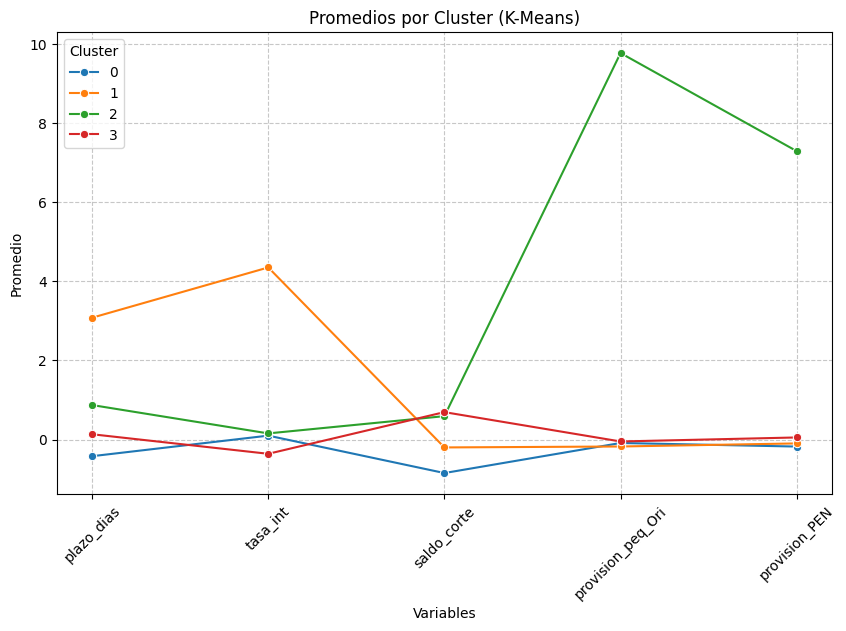

In [83]:
# Caracterización de clusters
# =============================================================================
cluster_means = datosK.groupby("Cluster").mean()

plt.figure(figsize=(10, 6))
sns.lineplot(data=cluster_means.T, marker="o", dashes=False, palette="tab10")
plt.xlabel("Variables")
plt.ylabel("Promedio")
plt.title("Promedios por Cluster (K-Means)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.show()

# <font face="gotham" color="purple"> **4. RFM**</font>

In [94]:
# Paquetería
# =============================================================================
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [95]:
# Datos y setup
# =============================================================================
df = pd.read_csv("plazavea.csv")
df["Fecha_Compra"] = pd.to_datetime(df["Fecha_Compra"])

,Cliente,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segmento
0,Cliente_1,10,9,481.261532,3,4,4,344,Cliente VIP
1,Cliente_100,1,3,78.366491,4,1,1,411,Cliente en Riesgo
2,Cliente_11,10,3,128.278173,3,1,1,311,Cliente en Riesgo
3,Cliente_12,4,4,126.683066,4,2,1,421,Otro
4,Cliente_13,42,3,138.637351,1,1,1,111,Cliente Perdido


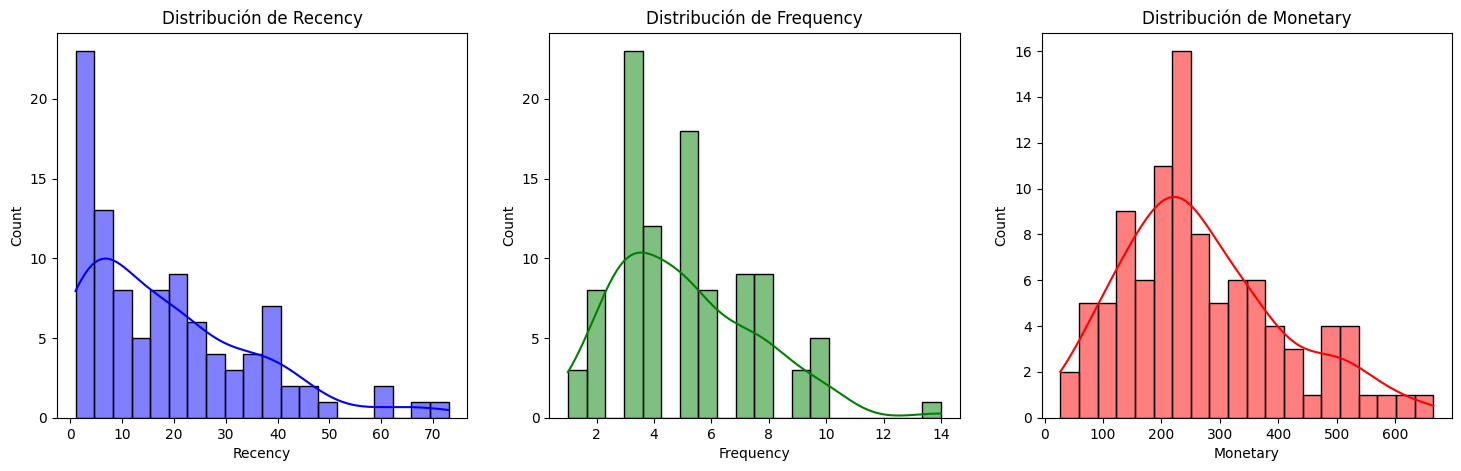

In [96]:
# Caracterización
# =============================================================================
# Definir la fecha de ref para calcular Recency (última compra registrada + 1 día)
fecha_ref = df["Fecha_Compra"].max() + pd.Timedelta(days=1)

# Calcular RFM
rfm = df.groupby("Cliente").agg(
    Recency=("Fecha_Compra", lambda x: (fecha_ref - x.max()).days),
    Frequency=("Cliente", "count"),
    Monetary=("Monto", "sum")
).reset_index()

# Visualización de la distribución de RFM
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(rfm["Recency"], bins=20, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribución de Recency")

sns.histplot(rfm["Frequency"], bins=20, kde=True, ax=axes[1], color="green")
axes[1].set_title("Distribución de Frequency")

sns.histplot(rfm["Monetary"], bins=20, kde=True, ax=axes[2], color="red")
axes[2].set_title("Distribución de Monetary")

# Asignar percentiles para segmentación
rfm["R"] = pd.qcut(rfm["Recency"], 4, labels=[4, 3, 2, 1])
rfm["F"] = pd.qcut(rfm["Frequency"], 4, labels=[1, 2, 3, 4])
rfm["M"] = pd.qcut(rfm["Monetary"], 4, labels=[1, 2, 3, 4])

# Crear Score RFM
rfm["RFM_Score"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)

# Asignar segmentos de clientes
def segmentar_cliente(rfm_score):
    if rfm_score in ["444", "433", "343", "344"]:
        return "Cliente VIP"
    elif rfm_score in ["334", "343", "433", "423"]:
        return "Cliente Leal"
    elif rfm_score in ["144", "134", "124"]:
        return "Cliente Nuevo"
    elif rfm_score in ["411", "311", "211"]:
        return "Cliente en Riesgo"
    elif rfm_score in ["111", "112", "121"]:
        return "Cliente Perdido"
    else:
        return "Otro"

rfm["Segmento"] = rfm["RFM_Score"].apply(segmentar_cliente)

# Mostrar primeros resultados
rfm.head()


In [ ]:
# Tipos de clientes
